In [1]:
import numpy as np
import keras
import tensorflow as tf
import effector
from sklearn.datasets import fetch_california_housing
import tabpfn
import time

california_housing = fetch_california_housing(as_frame=True)

2025-02-26 11:16:45.248689: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
np.random.seed(21)

In [3]:
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [4]:
feature_names = california_housing.feature_names
target_name= california_housing.target_names[0]
df = type(california_housing.frame)

In [5]:
X = california_housing.data
y = california_housing.target

In [6]:
print("Design matrix shape: {}".format(X.shape))
print("---------------------------------")
for col_name in X.columns:
    print("Feature: {:15}, unique: {:4d}, Mean: {:6.2f}, Std: {:6.2f}, Min: {:6.2f}, Max: {:6.2f}".format(col_name, len(X[col_name].unique()), X[col_name].mean(), X[col_name].std(), X[col_name].min(), X[col_name].max()))
    
print("\nTarget shape: {}".format(y.shape))
print("---------------------------------")
print("Target: {:15}, unique: {:4d}, Mean: {:6.2f}, Std: {:6.2f}, Min: {:6.2f}, Max: {:6.2f}".format(y.name, len(y.unique()), y.mean(), y.std(), y.min(), y.max()))

Design matrix shape: (20640, 8)
---------------------------------
Feature: MedInc         , unique: 12928, Mean:   3.87, Std:   1.90, Min:   0.50, Max:  15.00
Feature: HouseAge       , unique:   52, Mean:  28.64, Std:  12.59, Min:   1.00, Max:  52.00
Feature: AveRooms       , unique: 19392, Mean:   5.43, Std:   2.47, Min:   0.85, Max: 141.91
Feature: AveBedrms      , unique: 14233, Mean:   1.10, Std:   0.47, Min:   0.33, Max:  34.07
Feature: Population     , unique: 3888, Mean: 1425.48, Std: 1132.46, Min:   3.00, Max: 35682.00
Feature: AveOccup       , unique: 18841, Mean:   3.07, Std:  10.39, Min:   0.69, Max: 1243.33
Feature: Latitude       , unique:  862, Mean:  35.63, Std:   2.14, Min:  32.54, Max:  41.95
Feature: Longitude      , unique:  844, Mean: -119.57, Std:   2.00, Min: -124.35, Max: -114.31

Target shape: (20640,)
---------------------------------
Target: MedHouseVal    , unique: 3842, Mean:   2.07, Std:   1.15, Min:   0.15, Max:   5.00


In [7]:
def preprocess(X, y):
    # Compute mean and std for outlier detection
    X_mean = X.mean()
    X_std = X.std()
    
    # Exclude instances with any feature 2 std away from the mean
    mask = (X - X_mean).abs() <= 2 * X_std
    mask = mask.all(axis=1)
    
    X_filtered = X[mask]
    y_filtered = y[mask]

    # Standardize X
    X_mean = X_filtered.mean()
    X_std = X_filtered.std()
    X_standardized = (X_filtered - X_mean) / X_std

    # Standardize y
    y_mean = y_filtered.mean()
    y_std = y_filtered.std()
    y_standardized = (y_filtered - y_mean) / y_std

    return X_standardized, y_standardized, X_mean, X_std, y_mean, y_std



# shuffle and standarize all features
X_df, Y_df, x_mean, x_std, y_mean, y_std = preprocess(X, y)

In [8]:
def split(X_df, Y_df):
    # shuffle indices
    indices = np.arange(len(X_df))
    np.random.shuffle(indices)
    
    # data split
    train_size = int(0.8 * len(X_df))
    
    X_train = X_df.iloc[indices[:train_size]]
    Y_train = Y_df.iloc[indices[:train_size]]
    X_test = X_df.iloc[indices[train_size:]]
    Y_test = Y_df.iloc[indices[train_size:]]
    
    return X_train, Y_train, X_test, Y_test

# train/test split
X_train, Y_train, X_test, Y_test = split(X_df, Y_df)

In [9]:
X_train = X_train[:500].to_numpy()
Y_train = Y_train[:500].to_numpy()
X_test = X_test[:500].to_numpy()
Y_test = Y_test[:500].to_numpy()

In [10]:
model = tabpfn.TabPFNRegressor(n_jobs=7, device="cpu")
model.fit(X_train, Y_train)

TabPFNRegressor(device='cpu', n_jobs=7)

In [11]:
def model_forward(x):
    return model.predict(x)

In [12]:
scale_y = {"mean": y_mean, "std": y_std}
scale_x_list =[{"mean": x_mean.iloc[i], "std": x_std.iloc[i]} for i in range(len(x_mean))]

In [13]:
y_limits = [0, 4]
dy_limits = [-3, 3]

## Global effects

In [14]:
ale = effector.ALE(data=X_test, model=model_forward, feature_names=feature_names, target_name=target_name, nof_instances="all")

In [15]:
tic = time.time()
ale.fit("all", centering=True)
toc = time.time()
print(toc - tic)

/home/givasile/miniconda3/envs/effector-dev/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


256.08621978759766


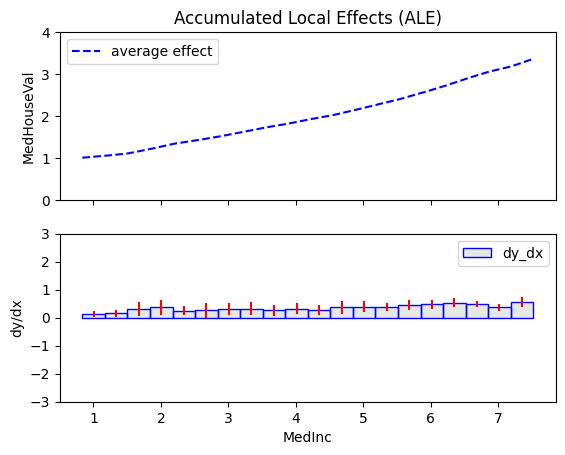

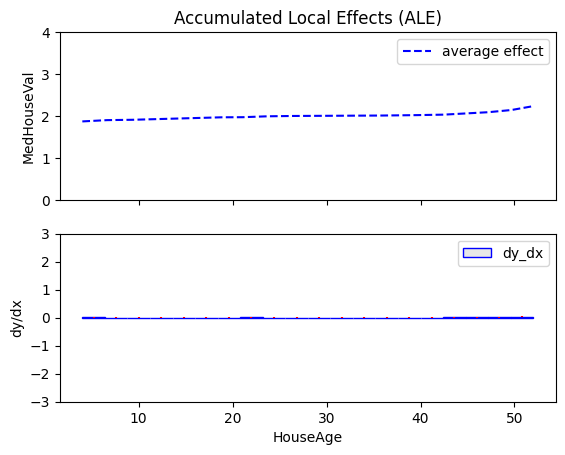

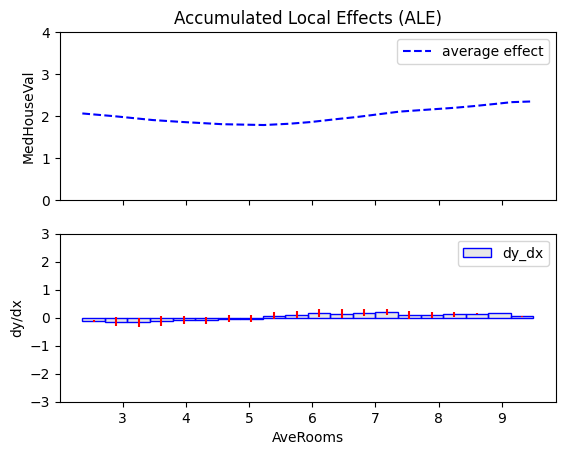

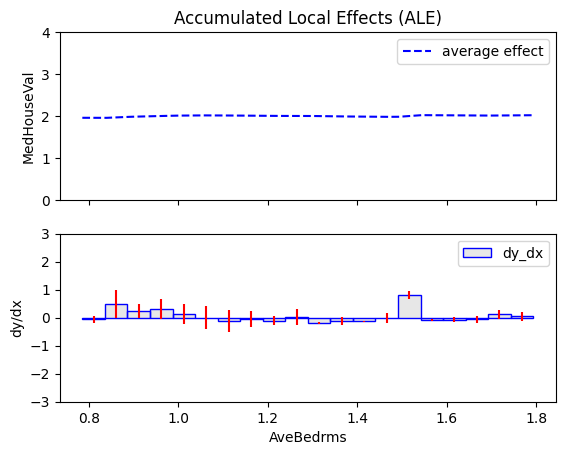

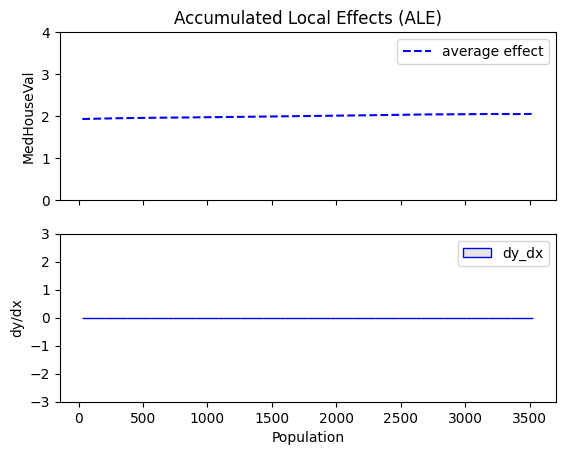

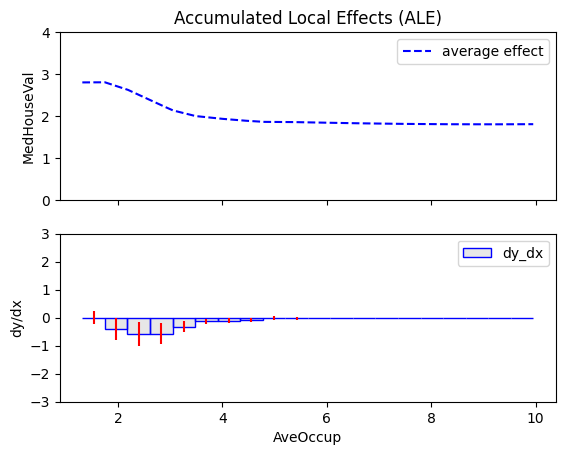

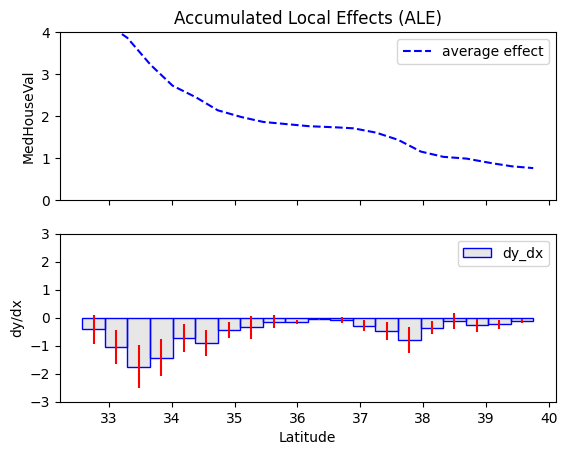

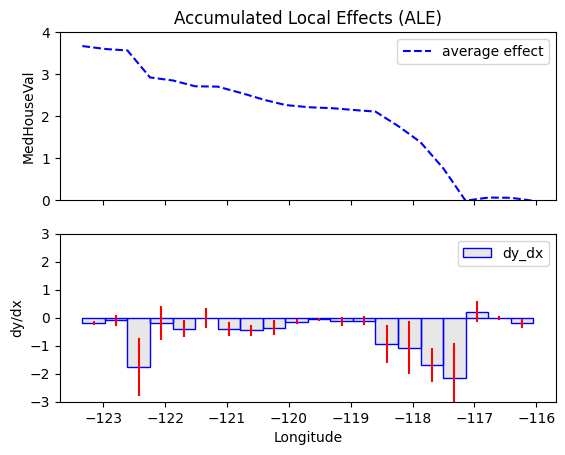

In [16]:
for i in range(8):
    ale.plot(feature=i, centering=True, scale_x=scale_x_list[i], scale_y=scale_y, y_limits=y_limits, dy_limits=dy_limits)

## Regional Effects

In [17]:
r_ale = effector.RegionalALE(data=X_train, model=model_forward, feature_names=feature_names, target_name=target_name)

## Latitude (south to north)

In [18]:
r_ale.summary(features=6, scale_x_list=scale_x_list)

100%|██████████| 1/1 [00:32<00:00, 32.79s/it]



Feature 6 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
Latitude 🔹 [id: 0 | heter: 0.57 | inst: 500 | w: 1.00]
    Longitude ≤ -120.76 🔹 [id: 1 | heter: 0.09 | inst: 180 | w: 0.36]
        MedInc ≤ 4.55 🔹 [id: 3 | heter: 0.09 | inst: 126 | w: 0.25]
        MedInc > 4.55 🔹 [id: 4 | heter: 0.10 | inst: 54 | w: 0.11]
    Longitude > -120.76 🔹 [id: 2 | heter: 0.48 | inst: 320 | w: 0.64]
        MedInc ≤ 4.55 🔹 [id: 5 | heter: 0.31 | inst: 228 | w: 0.46]
        MedInc > 4.55 🔹 [id: 6 | heter: 0.43 | inst: 92 | w: 0.18]
--------------------------------------------------
Feature 6 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.57
    Level 1🔹heter: 0.34 | 🔻0.23 (40.23%)
        Level 2🔹heter: 0.25 | 🔻0.09 (26.41%)




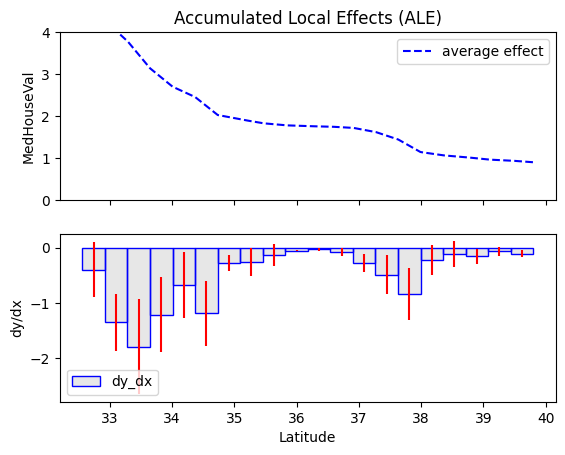

In [19]:
r_ale.plot(feature=6, node_idx=0, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

**Global Trend:** House prices decrease as we move north.  

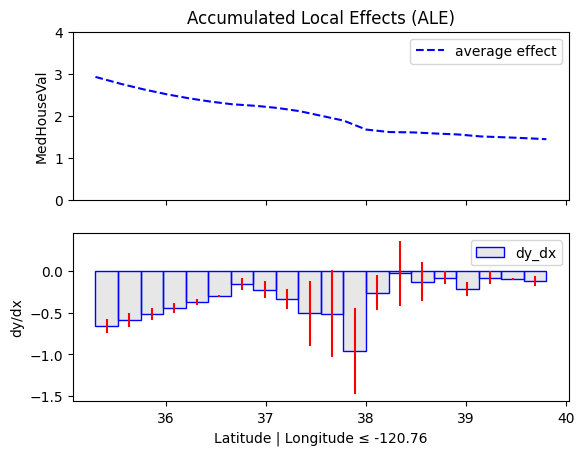

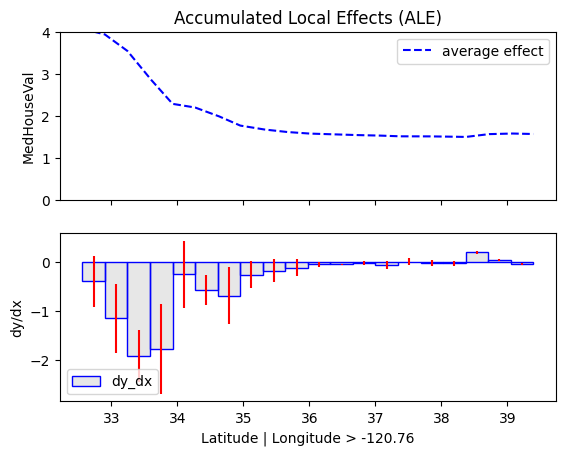

In [20]:
for node_idx in [1, 2]:
    r_ale.plot(feature=6, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

**Global Trend:** House prices decrease as we move north.  

**Regional Trends:** Moreorless the same, with minor different curves.

## Longitude (west to east)

100%|██████████| 1/1 [00:31<00:00, 31.17s/it]


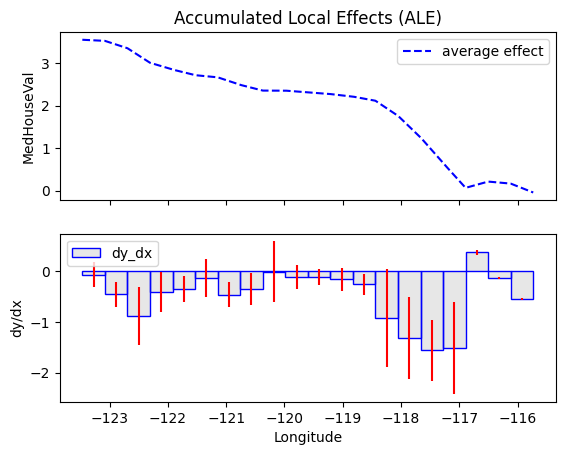

In [21]:
r_ale.plot(feature=7, node_idx=0, centering=True, scale_x_list=scale_x_list, scale_y=scale_y)

**Global Trend:** House prices decrease as we move east.  

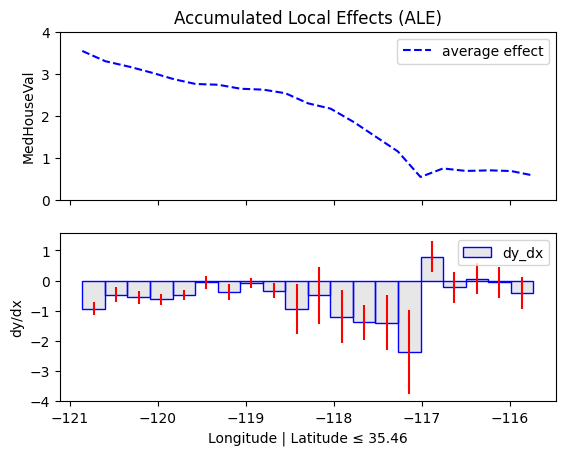

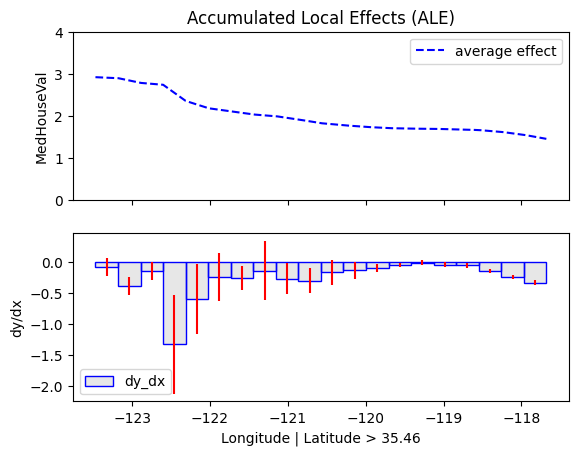

In [22]:
for node_idx in [1, 2]:
    r_ale.plot(feature=7, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

**Global Trend:** House prices decrease as we move east.  

**Regional Trends:**  
- **North (latitude > 35.85):** Prices drop more sharply in the first half from east to west.  
- **South (latitude < 35.85):** Prices drop more sharply in the second half from east to west.